# Set Up PySpark

In [ ]:
!pip install pyspark
!pip install findspark

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [ ]:
spark=SparkSession.builder\
    .master("local[*]")\
    .appName("Clustering")\
    .getOrCreate()

# Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
from pathlib import Path
current_dir = '/content/drive/MyDrive'
data_relative_path = 'Data/splited_data_NoOutliers_featureSelected'

X_train = spark.read.csv(os.path.join(current_dir, data_relative_path, "X_train.csv"), header=True, inferSchema=True)
X_test  = spark.read.csv(os.path.join(current_dir, data_relative_path, "X_test.csv"), header=True, inferSchema=True)

In [ ]:
from pyspark.sql import DataFrame
full_data = X_train.union(X_test)

# first we should remove the outliers and scale the data

## remove outliers

In [ ]:
# already removed

## scale the data

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

In [ ]:
numeric_cols = full_data.columns

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
assembled_data = assembler.transform(full_data)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)# why -> more suitable for Kmeans and PCA
scaled_data = scaler.fit(assembled_data).transform(assembled_data)

df_scaled = scaled_data.select("scaled_features")

In [ ]:
df_scaled.show(5)

+--------------------+
|     scaled_features|
+--------------------+
|[-0.6951883698483...|
|[-0.6951883698483...|
|[1.43844993028226...|
|[1.43844993028226...|
|[1.43844993028226...|
+--------------------+
only showing top 5 rows



# Clustering

## check if the kmean will take reasonal time before checking best number of clusters -> otherwise apply PCA

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans

In [ ]:
kmeans = KMeans(k=3, seed=1, featuresCol="scaled_features", predictionCol="prediction")
model = kmeans.fit(df_scaled)
predictions = model.transform(df_scaled)

In [ ]:
predictions.show(5)

+--------------------+----------+
|     scaled_features|prediction|
+--------------------+----------+
|[-0.6951883698483...|         0|
|[-0.6951883698483...|         0|
|[1.43844993028226...|         0|
|[1.43844993028226...|         2|
|[1.43844993028226...|         0|
+--------------------+----------+
only showing top 5 rows



In [ ]:
# takes reasonal time

## Check the best #Cluster



### WSS (Elbow Method)

In [ ]:
wss = []

for k in range(2, 11):
    kmeans = KMeans(k=k, seed=1, featuresCol="scaled_features", predictionCol="prediction")
    model = kmeans.fit(df_scaled)
    wss.append(model.summary.trainingCost)
    print(f"Cluster Centers for k={k}: {model.clusterCenters()}")


Cluster Centers for k=2: [array([ 3.32223138e-02,  1.06732842e-02, -2.64422259e-02, -8.61530433e-02,
       -2.78300084e-02, -3.14007482e-02, -1.07217134e-02,  2.27254770e-02,
        3.34704417e-02,  0.00000000e+00,  4.92742423e-02,  6.08038601e-02,
       -5.04249339e-04,  1.24630655e-02, -4.84731314e-02,  1.93296214e-02,
        4.75645306e-03,  1.78718947e-03,  2.44320656e-02,  1.64935608e-02,
        1.56340778e-02,  2.32820804e-02,  2.50878497e-02, -2.60152129e-02,
       -1.07877943e-02,  1.04062702e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.08565818e-02, -7.51880255e-02, -3.90980583e-01,
       -5.30791871e-01, -2.78128023e-01, -3.17360139e-01, -5.04368682e-02,
       -2.60744739e-01,  7.12978702e-02, -3.27673858e-01, -4.29267852e-01,
       -3.00230472e-01, -1.17905911e-01, -4.51407921e-02, -4.65412471e-01,
       -2.77159993e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -3.47550677e-01, -1.17046599e-01, -6.25346720e-02,  0.00000000e+00,

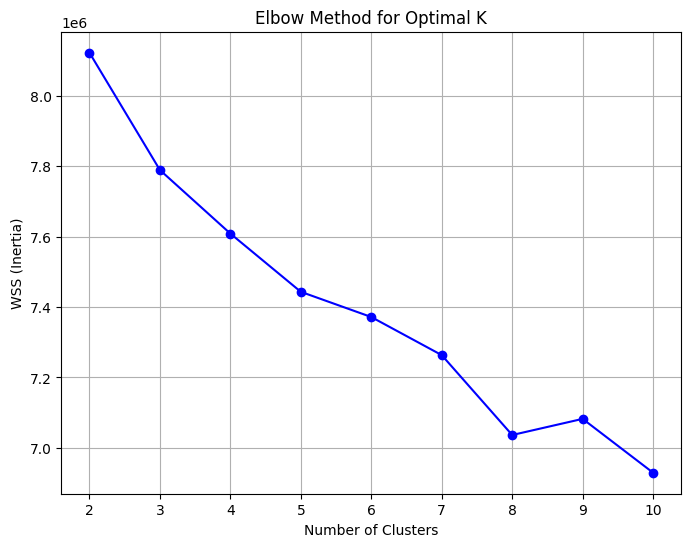

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), wss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS (Inertia)')
plt.grid(True)
plt.show()

### silhouette Score

In [ ]:
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(k=k, seed=1, featuresCol="scaled_features", predictionCol="prediction")

    model = kmeans.fit(df_scaled)

    predictions = model.transform(df_scaled)

    evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="scaled_features")

    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

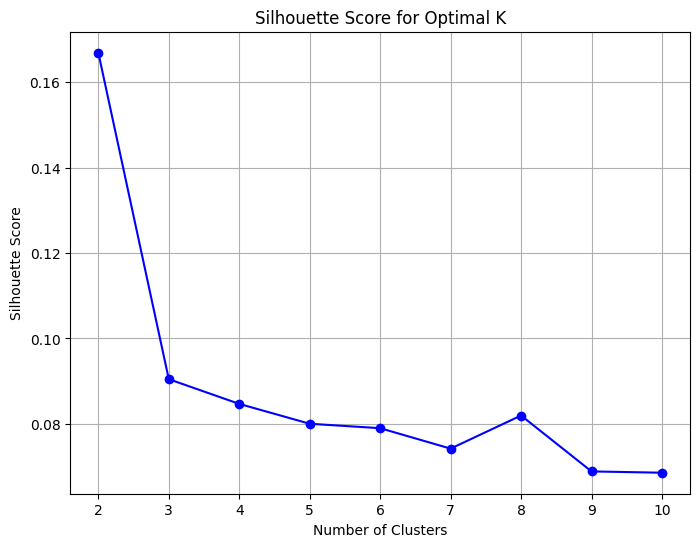

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

### the best number is not clear & we do not have info from the field -> we will choose 5

In [ ]:
kmeans = KMeans(k=5, seed=1, featuresCol="scaled_features", predictionCol="prediction")
model = kmeans.fit(df_scaled)
predictions = model.transform(df_scaled)

In [ ]:
predictions.show(5)

+--------------------+----------+
|     scaled_features|prediction|
+--------------------+----------+
|[-0.6951883698483...|         0|
|[-0.6951883698483...|         1|
|[1.43844993028226...|         0|
|[1.43844993028226...|         3|
|[1.43844993028226...|         3|
+--------------------+----------+
only showing top 5 rows



#### Show the distribution of the clusters

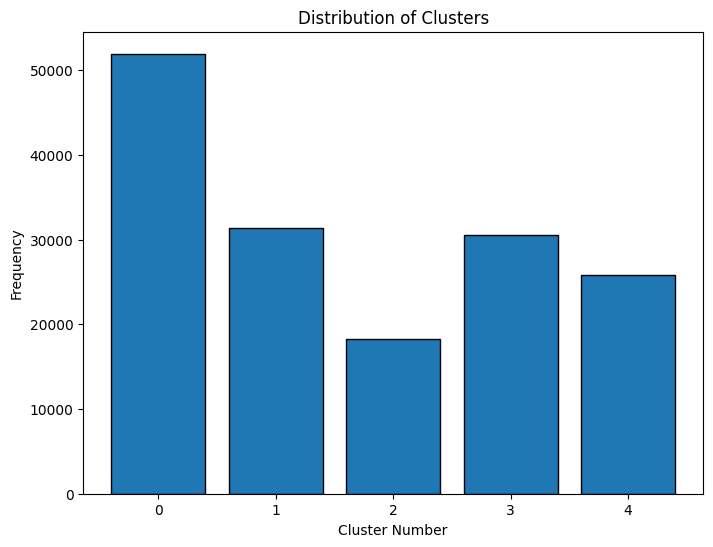

In [ ]:
cluster_counts = predictions.groupBy("prediction").count()

cluster_counts_pd = cluster_counts.toPandas()

plt.figure(figsize=(8, 6))
plt.bar(cluster_counts_pd['prediction'], cluster_counts_pd['count'], edgecolor='black')
plt.title('Distribution of Clusters')
plt.xlabel('Cluster Number')
plt.ylabel('Frequency')
plt.xticks(cluster_counts_pd['prediction'])
plt.show()